In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import linalg
from scipy.optimize import root

import sys
sys.path.insert(0, 'code')

from robot_data import Load_Lidar_Scans as load_scans
from robot_data import Lidar_Scan
from robot_data import robot_trajectory
from datafilters import filters
import coordinate_transforms as cord_trans
import visualizer
import ICP

# All the variables that have been created to retrieve the data:

In [2]:
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')

trajectory_OBJ = robot_trajectory()
trajectory_OBJ.load_trajectory('data\\Trajectory.txt')

print('Trajectory: ',trajectory_OBJ.trajectory.shape)
print('traj_len: ',trajectory_OBJ.trajectory_length)
print('traj_dim: ',trajectory_OBJ.trajectory_dimension,'\n')

print('LidarScans: ',scans_OBJ.LidarScan_ranges.shape)
print('num_of_lidarscans: ',scans_OBJ.num_of_LidarScans)
print('LidarScans_angles: ',scans_OBJ.LidarScan_angles.shape)

Trajectory:  (52, 3)
traj_len:  52
traj_dim:  2 

LidarScans:  (51, 240)
num_of_lidarscans:  240
LidarScans_angles:  (240,)


In [3]:
np.random.RandomState(seed=201196)

In [4]:
def sample_motion_normal(b):
    mu = 0
    sigma = np.sqrt(b)
    s = np.random.normal(mu, sigma, 12) 
    sampled_sum = 0
    for point in s:
        sampled_sum += point
    return sampled_sum/2

In [5]:
def sample_motion_triangle(b):
    mu = 0
    sigma = np.sqrt(b)
    sampled_points = np.random.normal(mu, sigma, 2) 
    return (np.sqrt(6)/2)*(sampled_points[0] + sampled_points[1])

In [11]:
def odo_sample(u,x_tneg1,sample_dist):
    xbar, ybar, thetabar = u[0,0], u[0,1], u[0,2]
    xbar_prime, ybar_prime, thetabar_prime = u[1,0], u[1,1], u[1,2]
    x, y, theta = x_tneg1[0], x_tneg1[1], x_tneg1[2]
    
    alpha = np.array([0.00005,0.00005,0.0005,0.2])
    
    delta_rot1 = np.arctan2(ybar_prime - ybar,xbar_prime - xbar) - thetabar
    delta_trans = np.sqrt(np.power((xbar - xbar_prime),2) + np.power((ybar - ybar_prime),2))
    delta_rot2 = thetabar_prime - thetabar - delta_rot1
    
    if sample_dist == 'N':
        hat_delta_rot1 =  delta_rot1 - sample_motion_normal(alpha[0]*np.power(delta_rot1,2) + alpha[1]*np.power(delta_trans,2))
        hat_delta_trans =  delta_trans - sample_motion_normal(alpha[2]*np.power(delta_trans,2) + alpha[3]*np.power(delta_rot1,2) + alpha[3]*np.power(delta_rot2,2))
        hat_delta_rot2 =  delta_rot2 - sample_motion_normal(alpha[0]*np.power(delta_rot2,2) + alpha[1]*np.power(delta_trans,2))
    else:
        hat_delta_rot1 =  delta_rot1 - sample_motion_triangle(alpha[0]*np.power(delta_rot1,2) + alpha[1]*np.power(delta_trans,2))
        hat_delta_trans =  delta_trans - sample_motion_triangle(alpha[2]*np.power(delta_trans,2) + alpha[3]*np.power(delta_rot1,2) + alpha[3]*np.power(delta_rot2,2))
        hat_delta_rot2 =  delta_rot2 - sample_motion_triangle(alpha[0]*np.power(delta_rot2,2) + alpha[1]*np.power(delta_trans,2))
    
    x_prime = x + hat_delta_trans*np.cos(theta + hat_delta_rot1)
    y_prime = y + hat_delta_trans*np.sin(theta + hat_delta_rot1)
    theta_prime = theta + hat_delta_rot1 + hat_delta_rot2
    return [x_prime,y_prime,theta_prime]

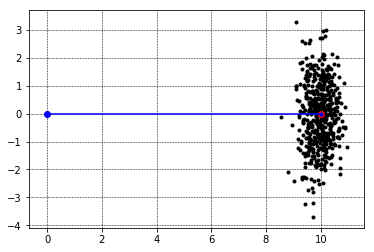

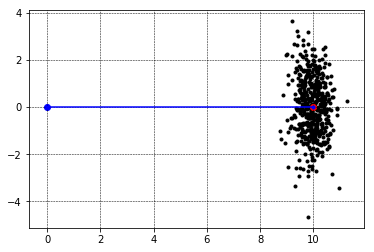

In [12]:
x_prev = np.array([0,0,0])
x_curr = np.array([10,0,0])
u_prev = np.vstack((x_prev,x_curr))

plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.plot([x_prev[0],x_curr[0]], [x_prev[1],x_curr[1]], 'b.-')
for i in range(500):
    point = odo_sample(u_prev,x_prev,'N')
    plt.scatter(point[0],point[1],marker='.',c='k')
    
plt.scatter(x_prev[0],x_prev[1],marker='o',c='b')
plt.scatter(x_curr[0],x_curr[1],marker='o',c='r')

plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.plot([x_prev[0],x_curr[0]], [x_prev[1],x_curr[1]], 'b.-')
for i in range(500):
    point = odo_sample(u_prev,x_prev,'T')
    plt.scatter(point[0],point[1],marker='.',c='k')
    
plt.scatter(x_prev[0],x_prev[1],marker='o',c='b')
plt.scatter(x_curr[0],x_curr[1],marker='o',c='r')

In [13]:
sequence = np.array([[0,0,0],[1,0,0],[2,0,0],[3,0,0],[3,1,np.pi/2],[3,2,np.pi/2],[3,3,np.pi/2],[2,3,np.pi],[1,3,np.pi],[0,3,np.pi]])
u_prev = np.zeros(3)
for i in range(sequence.shape[0]-1):    
    x_prev = sequence[i]
    x_curr = sequence[i+1]
    temp = np.vstack((x_prev,x_curr))
    u_prev = np.vstack((u_prev,temp))
    
u_prev = np.delete(u_prev,0,0)
steps = np.delete(np.linspace(0,u_prev.shape[0],int(u_prev.shape[0]/2+1),dtype='int'),-1,0)

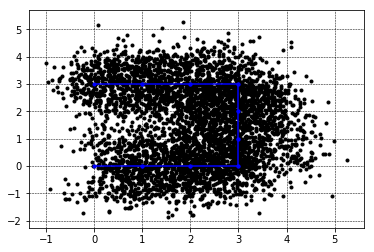

In [9]:
plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
for i,j in enumerate(steps):
    x_temp = sequence[i]
    u_temp = np.vstack((u_prev[j],u_prev[j+1]))
    for i in range(500):
        point = odo_sample(u_temp,x_temp,'N')
        plt.scatter(point[0],point[1],marker='.',c='k')
        
for i in range(sequence.shape[0]-1):
    plt.plot([sequence[i,0],sequence[i+1,0]], [sequence[i,1],sequence[i+1,1]], 'b.-')

TypeError: norm() missing 1 required positional argument: 'x'

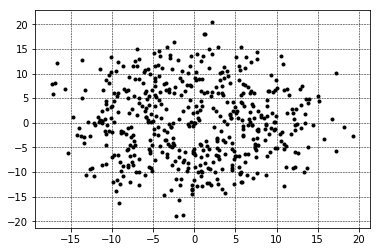

In [10]:
sequence = np.array([[0,0,0],[10,0,0],[20,0,0]])
u_prev = np.zeros(3)
for i in range(sequence.shape[0]-1):    
    x_prev = sequence[i]
    x_curr = sequence[i+1]
    temp = np.vstack((x_prev,x_curr))
    u_prev = np.vstack((u_prev,temp))
    
u_prev = np.delete(u_prev,0,0)
steps = np.delete(np.linspace(0,u_prev.shape[0],int(u_prev.shape[0]/2+1),dtype='int'),-1,0)

plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
gaussian = np.zeros(2)
for i,j in enumerate(steps):
    x_temp = sequence[i]
    u_temp = np.vstack((u_prev[j],u_prev[j+1]))
    for i in range(500):
        point = odo_sample(u_temp,x_temp,'N')
        gaussian = np.vstack((gaussian,point[:2]))
        plt.scatter(point[0],point[1],marker='.',c='k')
    gaussian = np.delete(gaussian,0,0)
    motion_model = np.linalg.norm()
    print(gaussian.shape)
        
for i in range(sequence.shape[0]-1):
    plt.plot([sequence[i,0],sequence[i+1,0]], [sequence[i,1],sequence[i+1,1]], 'b.-')

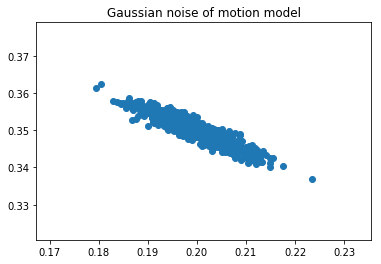

In [14]:
from math import *

import numpy as np

import matplotlib

import matplotlib.pyplot as plt

# translation distance

dx=0.2

dy=0.35

trans = sqrt(dx*dx + dy*dy)

# rotation1 = 30 degree

theta1 = 30.0*pi/180.0

# rotation2 = 10 degree

theta2 = 10.0*pi/180.0

 

rot1 = atan2(dy, dx) - theta1

rot2 = theta2-theta1-rot1

 

# the alpha parameters

a1 = 0.05

a2 = 15.0*pi/180.0

a3 = 0.05

a4 = 0.01

sd_rot1 = a1*abs(rot1) + a2*trans

sd_rot2 = a1*abs(rot2) + a2*trans

sd_trans = a3*trans + a4*(abs(rot1) + abs(rot2))

 

x= []

y = []

 

for i in range(0, 1000):

    t = trans  + np.random.normal(0,sd_trans*sd_trans)

    r1 = rot1 + np.random.normal(0, sd_rot1*sd_rot1)

    r2 = rot2 + np.random.normal(0, sd_rot2*sd_rot2)

    x.append(t*cos(theta1+r1))

    y.append(t*sin(theta1+r1))

 

fig, ax = plt.subplots()

#ax.plot(x, y)

ax.scatter(x, y)

ax.set_title('Gaussian noise of motion model')

plt.show()


# XXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
def gauss_MM():
    
    return

In [ ]:
gauss_MM()

In [ ]:
def exponential_MM():
    return

In [ ]:
def uniform_max_MM():
    s = np.random.uniform(9,10,1000)
    count, bins, ignored = plt.hist(s, 1, density=True, color='w')
    plt.plot(bins, np.ones_like(bins), linewidth=2, color='k')
    plt.plot([[10],[10]],[[0],[1]], linewidth=2, color='k')
    plt.plot([[9],[9]],[[0],[1]], linewidth=2, color='k')
    return

In [ ]:
uniform_max_MM()

In [ ]:
def uniform_noise_MM():
    s = np.random.uniform(0,10,1000)
    count, bins, ignored = plt.hist(s, 1, density=True, color='w')
    plt.plot([[0],[10]],[[0.1],[0.1]], linewidth=2, color='k')
    plt.plot([[10],[10]],[[0],[0.1]], linewidth=2, color='k')
    plt.plot([[0],[0]],[[0],[0.1]], linewidth=2, color='k')
    return

In [ ]:
uniform_noise_MM()

In [ ]:
x1 = np.array([0,0,1])
x2 = np.array([2,2,1])
edge = np.invert(x1)*x2
print(edge)